### Step 1. Prepare Dataset + DataLoader

In [1]:
import torch
from torch.utils.data import Dataset

class Twitter15Dataset(Dataset):
    def __init__(self, graph_data_list):
        """
        Initializes the dataset with a list of graph data.

        Args:
            graph_data_list (list): List of graph dictionaries. 
                                    Each dictionary contains:
                                    - 'x': node features tensor of shape (seq_len, feature_dim)
                                    - 'edge_index': edge index tensor of shape (2, num_edges)
                                    - 'y': label (int in range 0~3)
        """
        self.graphs = graph_data_list

    def __len__(self):
        # Returns the total number of graphs
        return len(self.graphs)

    def __getitem__(self, idx):
        # Retrieves the graph at index `idx`
        graph = self.graphs[idx]
        x = graph['x']  # Node features
        edge_index = graph['edge_index']  # Edge indices
        y = graph['y']  # Graph label

        return x, edge_index, y

def collate_fn(batch): 
    """
    Custom collate function to batch variable-length graph data.

    Args:
        batch (list of tuples): Each tuple is (x, edge_index, y)

    Returns:
        padded_xs (Tensor): Padded node features (batch_size, max_len, feature_dim)
        masks (Tensor): Boolean masks indicating valid node positions (batch_size, max_len)
        new_edge_indices (list): List of edge_index tensors (no batching done here)
        ys (Tensor): Labels (batch_size,)
    """
    xs, edge_indices, ys = zip(*batch)

    max_len = max(x.shape[0] for x in xs)  # Maximum sequence length in batch
    feature_dim = xs[0].shape[1]           # Dimensionality of node features

    padded_xs = []
    masks = []
    new_edge_indices = []

    for idx, (x, edge_index) in enumerate(zip(xs, edge_indices)):
        seq_len = x.shape[0]
        pad_len = max_len - seq_len

        # Pad x to max_len if needed
        if pad_len > 0:
            pad = torch.zeros((pad_len, feature_dim), dtype=x.dtype)
            x_padded = torch.cat([x, pad], dim=0)
        else:
            x_padded = x

        padded_xs.append(x_padded)

        # Create mask: 1 for valid tokens, 0 for padding
        mask = torch.cat([torch.ones(seq_len), torch.zeros(pad_len)]).bool()
        masks.append(mask)

        # Edge indices are kept as is (no padding needed)
        new_edge_indices.append(edge_index)

    padded_xs = torch.stack(padded_xs)  # Stack padded features
    masks = torch.stack(masks)          # Stack masks
    ys = torch.tensor(ys)               # Convert labels to tensor

    return padded_xs, masks, new_edge_indices, ys


In [2]:
from sklearn.model_selection import train_test_split

# Load preprocessed graph data from file. Each item in the list is a graph (as a dictionary).
# weights_only=False ensures full object is loaded (not just model weights).
graph_data_list = torch.load("../processed/twitter15_graph_data_clean.pt", weights_only=False)

# Split the data into Train (70%) and Temp (30%) using a fixed random seed for reproducibility
train_graphs, temp_graphs = train_test_split(graph_data_list, test_size=0.3, random_state=42)

# Further split Temp into Validation (15%) and Test (15%) -> 0.5 * 30% = 15%
val_graphs, test_graphs = train_test_split(temp_graphs, test_size=0.5, random_state=42)

# Print the number of samples in each split
print(f"Train: {len(train_graphs)}, Val: {len(val_graphs)}, Test: {len(test_graphs)}")


Train: 1043, Val: 223, Test: 224


In [3]:
from torch.utils.data import DataLoader

batch_size = 16  # Number of samples per batch during training and evaluation

# Wrap the graph lists into PyTorch Dataset objects
train_dataset = Twitter15Dataset(train_graphs)
val_dataset = Twitter15Dataset(val_graphs)
test_dataset = Twitter15Dataset(test_graphs)

# Create DataLoaders to efficiently load data in batches
# - shuffle=True for training to randomize sample order
# - collate_fn=collate_fn handles padding and batching of variable-length graph inputs
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print("DataLoaders created successfully!")


DataLoaders created successfully!


### Step 2: MambaEncoder + Pooling + MLP classifier

In [4]:
import torch
import torch.nn as nn
from mamba_ssm import Mamba                  # Sequence modeling block
from torch_geometric.nn import GCNConv       # Graph Convolutional Network layer

# Simple classification head: 2-layer MLP with ReLU activation
class ClassifierHead(nn.Module):
    def __init__(self, hidden_dim=256, num_classes=4):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

# Mamba-based encoder for sequential (graph node) input
class MambaEncoder(nn.Module):
    def __init__(self, input_dim=833, hidden_dim=128, num_layers=2, dropout_rate=0.2):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)  # Project input to hidden dimension
        self.layers = nn.ModuleList([
            nn.Sequential(
                Mamba(d_model=hidden_dim),               # Mamba sequence layer
                nn.Dropout(dropout_rate)                 # Dropout for regularization
            ) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(hidden_dim)             # Normalize output

    def forward(self, x, mask):
        """
        Args:
            x: (batch_size, seq_len, input_dim)
            mask: (batch_size, seq_len) -> boolean tensor indicating valid positions
        Returns:
            x: (batch_size, seq_len, hidden_dim)
        """
        x = self.input_proj(x)
        for layer in self.layers:
            x = layer(x)
        x = self.norm(x)
        return x

# Pooling layer: averages node representations, ignoring padded positions
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, mask):
        """
        Args:
            x: (batch_size, seq_len, hidden_dim)
            mask: (batch_size, seq_len)
        Returns:
            pooled: (batch_size, hidden_dim)
        """
        mask = mask.unsqueeze(-1)              # (batch_size, seq_len, 1)
        x = x * mask                           # Zero out padded positions
        sum_x = x.sum(dim=1)                   # Sum over valid positions
        lengths = mask.sum(dim=1)              # Count of valid positions
        pooled = sum_x / lengths.clamp(min=1e-6)  # Mean pooling
        return pooled

# Full classifier combining Mamba + GCN + Pooling + Classification head
class MambaClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super().__init__()
        self.input_norm = nn.LayerNorm(input_dim)  # Normalize input features
        self.encoder = MambaEncoder(input_dim, hidden_dim, num_layers)

        self.gnn_layer = GCNConv(hidden_dim, hidden_dim)  # GraphConv on encoded node features

        self.pooling = MeanPooling()
        self.classifier = ClassifierHead(hidden_dim, num_classes)

    def forward(self, x, mask, edge_indices):
        """
        Args:
            x: (batch_size, seq_len, input_dim)
            mask: (batch_size, seq_len)
            edge_indices: list of (2, num_edges) tensors (graph structure for each sample)
        Returns:
            logits: (batch_size, num_classes)
        """
        x = self.input_norm(x)                 # Normalize input

        h = self.encoder(x, mask)              # Encode with Mamba layers -> (B, L, D)

        # Apply GCN layer to each sample in the batch independently
        h_gnn = []
        for i in range(h.shape[0]):
            hi = h[i]                          # (seq_len, hidden_dim)
            ei = edge_indices[i].to(hi.device)  # Edge index for graph i

            if ei.numel() == 0:                # If no edges, skip GCN
                hi_gnn = hi
            else:
                hi_gnn = self.gnn_layer(hi, ei)

            h_gnn.append(hi_gnn)

        h = torch.stack(h_gnn, dim=0)          # (batch_size, seq_len, hidden_dim)

        pooled = self.pooling(h, mask)         # Mean pool over valid nodes
        logits = self.classifier(pooled)       # Predict class logits

        logits = torch.clamp(logits, min=-10, max=10)  # Clamp for numerical stability
        return logits


### Step 3. Trainer

In [15]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score

# Train the model for one epoch
def train_one_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    all_preds = []   # Store predictions
    all_labels = []  # Store true labels

    for x, mask, edge_indices, y in train_loader:
        x = x.to(device)
        mask = mask.to(device)
        y = y.to(device)

        # Move each tensor in edge_indices to the device
        edge_indices = [ei.to(device) for ei in edge_indices]

        # Replace NaNs in input with 0
        x = torch.nan_to_num(x, nan=0.0)

        optimizer.zero_grad()  # Reset gradients
        logits = model(x, mask, edge_indices)  # Forward pass

        # Debugging: Check for NaN or Inf in outputs
        if torch.isnan(logits).any() or torch.isinf(logits).any():
            print("⚠️ Problematic batch detected!")
            print(f"x shape: {x.shape}")
            print(f"mask sum: {mask.sum(dim=1)}")
            print(f"y: {y}")
            print(f"logits max: {torch.nanmax(logits)}, min: {torch.nanmin(logits)}")
            continue

        loss = loss_fn(logits, y)  # Compute loss
        loss.backward()  # Backpropagation
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()  # Update parameters

        running_loss += loss.item() * x.size(0)  # Accumulate batch loss

        preds = logits.argmax(dim=-1)  # Get predicted class
        all_preds.extend(preds.detach().cpu().tolist())  # Save predictions
        all_labels.extend(y.cpu().tolist())  # Save true labels

    epoch_loss = running_loss / len(train_loader.dataset)  # Average loss
    epoch_acc = accuracy_score(all_labels, all_preds)      # Accuracy
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')  # Macro F1-score

    return epoch_loss, epoch_acc, epoch_f1


# Evaluate the model on validation data for one epoch
def evaluate_one_epoch(model, val_loader, loss_fn, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for x, mask, edge_indices, y in val_loader:
            x = x.to(device)
            mask = mask.to(device)
            y = y.to(device)
            edge_indices = [ei.to(device) for ei in edge_indices]

            logits = model(x, mask, edge_indices)
            logits = torch.clamp(logits, min=-10, max=10)  # Clip output range

            # Skip batch if output contains NaN or Inf
            if torch.isnan(logits).any() or torch.isinf(logits).any():
                continue

            loss = loss_fn(logits, y)
            running_loss += loss.item() * x.size(0)

            preds = logits.argmax(dim=-1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    return epoch_loss, epoch_acc, epoch_f1


# Class to stop training early if performance does not improve
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0.0):
        """
        Args:
            patience (int): How many epochs to wait after last improvement
            verbose (bool): Print message when early stopping
            delta (float): Minimum change to qualify as improvement
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_f1 = -float('inf')

    # Call this function after each validation epoch
    def __call__(self, val_f1, model):
        score = val_f1  # Use F1-score as the metric

        if self.best_score is None:
            self.best_score = score
            self.best_f1 = val_f1
        elif score < self.best_score + self.delta:
            # No improvement
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True  # Trigger early stopping
        else:
            # Improvement observed
            self.best_score = score
            self.best_f1 = val_f1
            self.counter = 0  # Reset counter


### Step 4: Runner

In [17]:
import torch
import torch.nn as nn
from torch.optim import AdamW
import os
import random
import numpy as np
import pandas as pd

# Set all random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set random seed
set_seed(42)

# Create directory for saving model checkpoints
os.makedirs("../checkpoints", exist_ok=True)

# Set device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define hyperparameter grid
batch_size = 32
hidden_dim = 128
num_layers = 2
num_classes = 4

learning_rates = [5e-5, 1e-4]
weight_decays = [1e-2, 5e-2]
patience = 10
max_epochs = 60

# Assume train_loader, val_loader, and test_loader are already defined

# Define label smoothing cross entropy loss
from torch.nn import functional as F

def smooth_cross_entropy(preds, targets, smoothing=0.1):
    confidence = 1.0 - smoothing
    logprobs = F.log_softmax(preds, dim=-1)
    nll_loss = -logprobs.gather(dim=-1, index=targets.unsqueeze(1)).squeeze(1)
    smooth_loss = -logprobs.mean(dim=-1)
    loss = confidence * nll_loss + smoothing * smooth_loss
    return loss.mean()

loss_fn = smooth_cross_entropy

# Store results of each hyperparameter configuration
results = []

# Track the best model
best_val_f1 = -float('inf')
best_model_state = None
best_hparams = None

# Grid search over learning rates and weight decays
for lr in learning_rates:
    for wd in weight_decays:
        print(f"\n Training with lr={lr}, weight_decay={wd}")

        # Reinitialize the model and optimizer for each run
        model = MambaClassifier(
            input_dim=833,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            num_classes=num_classes
        ).to(device)

        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=wd)
        early_stopper = EarlyStopping(patience=patience, verbose=True)

        # Training loop
        for epoch in range(1, max_epochs + 1):
            train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
            val_loss, val_acc, val_f1 = evaluate_one_epoch(model, val_loader, loss_fn, device)

            print(f"Epoch {epoch}:")
            print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}")
            print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f} | Val   F1: {val_f1:.4f}")

            # Check early stopping condition
            early_stopper(val_f1, model)

            if early_stopper.early_stop:
                print("Early stopping triggered!")
                break

        # Log the result of this configuration
        results.append({
            "learning_rate": lr,
            "weight_decay": wd,
            "val_f1": early_stopper.best_f1
        })

        # Update the best model found so far
        if early_stopper.best_f1 > best_val_f1:
            best_val_f1 = early_stopper.best_f1
            best_model_state = model.state_dict()
            best_hparams = {"lr": lr, "weight_decay": wd}

# Save the best model to disk
save_path = "../checkpoints/best_model_v2.pt"
torch.save(best_model_state, save_path)

# Save all grid search results as a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv("../checkpoints/grid_search_results_v2.csv", index=False)

print("\n Grid Search completed!")
print(f"Best Hyperparameters: {best_hparams}")
print(f"Best Val F1: {best_val_f1:.4f}")



 Training with lr=5e-05, weight_decay=0.01
Epoch 1:
  Train Loss: 1.3822 | Train Acc: 0.2800 | Train F1: 0.2684
  Val   Loss: nan | Val   Acc: 0.2691 | Val   F1: 0.1898
Epoch 2:
  Train Loss: 1.3449 | Train Acc: 0.3624 | Train F1: 0.2937
  Val   Loss: nan | Val   Acc: 0.3587 | Val   F1: 0.3158
Epoch 3:
  Train Loss: 1.2716 | Train Acc: 0.4362 | Train F1: 0.3932
  Val   Loss: nan | Val   Acc: 0.4215 | Val   F1: 0.4174
Epoch 4:
  Train Loss: 1.2061 | Train Acc: 0.4880 | Train F1: 0.4682
  Val   Loss: nan | Val   Acc: 0.3543 | Val   F1: 0.3420
EarlyStopping counter: 1 out of 10
Epoch 5:
  Train Loss: 1.1519 | Train Acc: 0.5398 | Train F1: 0.5359
  Val   Loss: nan | Val   Acc: 0.4439 | Val   F1: 0.4430
Epoch 6:
  Train Loss: 1.1034 | Train Acc: 0.5724 | Train F1: 0.5688
  Val   Loss: nan | Val   Acc: 0.4529 | Val   F1: 0.4367
EarlyStopping counter: 1 out of 10
Epoch 7:
  Train Loss: 1.0547 | Train Acc: 0.5973 | Train F1: 0.5897
  Val   Loss: nan | Val   Acc: 0.4709 | Val   F1: 0.4738
Epoc

### Step 5 Test Evaluation

Test Accuracy: 0.6027
Test Macro-F1: 0.6029


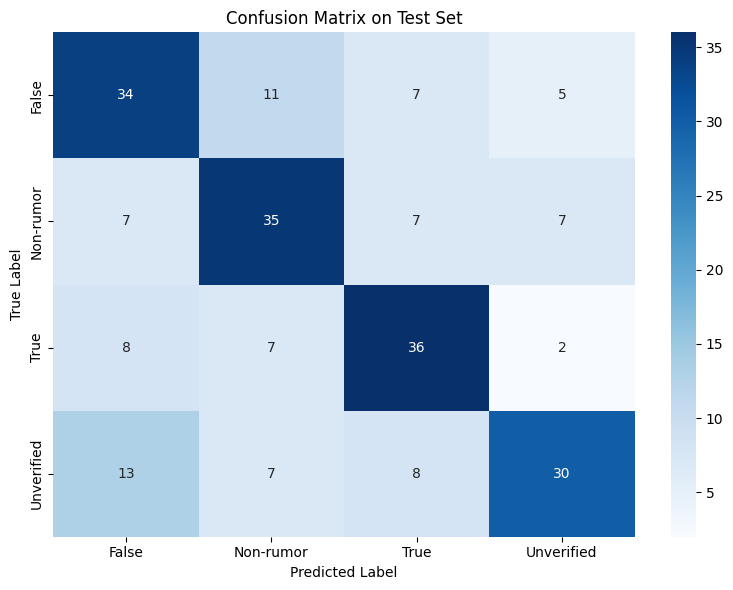

In [19]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# 1. Load the best saved model checkpoint
model.load_state_dict(torch.load("../checkpoints/best_model_v2.pt"))
model.to(device)
model.eval()  # Set model to evaluation mode

# 2. Evaluate model performance on the test dataset
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient computation for inference
    for x, mask, edge_index, y in test_loader:
        x = x.to(device)
        mask = mask.to(device)
        y = y.to(device)
    
        # Forward pass
        logits = model(x, mask, edge_index)
        preds = logits.argmax(dim=-1)  # Get predicted class
        
        # Store predictions and true labels
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(y.cpu().tolist())

# 3. Compute evaluation metrics: accuracy and macro-averaged F1 score
test_acc = accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Macro-F1: {test_f1:.4f}")

# 4. Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
            xticklabels=["False", "Non-rumor", "True", "Unverified"],
            yticklabels=["False", "Non-rumor", "True", "Unverified"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()
